Tracing forward pass...
Final output shape: torch.Size([1, 2])
Final output: tensor([[0.3453, 0.3010]])


<ipython-input-19-2708600298>:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


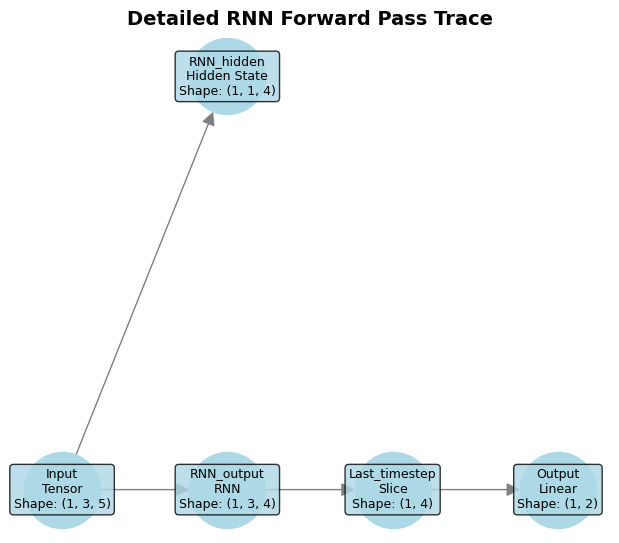

In [19]:
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt

class SimpleRNN(nn.Module):
    def __init__(self, input_size=5, hidden_size=4, output_size=2):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use last timestep
        return out

class ImprovedTracer:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.node_counter = 0
        self.layer_outputs = {}

    def add_node(self, name, shape, layer_type=""):
        node_id = f"{name}_{self.node_counter}"
        label = f"{name}\n{layer_type}\nShape: {shape}"
        self.graph.add_node(node_id, label=label, name=name)
        self.node_counter += 1
        return node_id

    def trace_model(self, model, input_tensor):
        # Add input node
        input_shape = tuple(input_tensor.shape)
        input_node = self.add_node("Input", input_shape, "Tensor")

        # Store current node for connections
        current_node = input_node

        # Manually trace through the model
        print("Tracing forward pass...")

        # RNN layer
        rnn_out, rnn_hidden = model.rnn(input_tensor)
        rnn_out_shape = tuple(rnn_out.shape)
        rnn_hidden_shape = tuple(rnn_hidden.shape)

        rnn_node = self.add_node("RNN_output", rnn_out_shape, "RNN")
        hidden_node = self.add_node("RNN_hidden", rnn_hidden_shape, "Hidden State")

        # Add edges
        self.graph.add_edge(current_node, rnn_node)
        self.graph.add_edge(current_node, hidden_node)

        # Take last timestep
        last_timestep = rnn_out[:, -1, :]
        last_shape = tuple(last_timestep.shape)
        last_node = self.add_node("Last_timestep", last_shape, "Slice")
        self.graph.add_edge(rnn_node, last_node)

        # Linear layer
        final_out = model.fc(last_timestep)
        final_shape = tuple(final_out.shape)
        final_node = self.add_node("Output", final_shape, "Linear")
        self.graph.add_edge(last_node, final_node)

        return final_out

    def visualize(self, figsize=(6, 5)):
        plt.figure(figsize=figsize)

        # Create a hierarchical layout
        pos = {}
        layers = {}

        # Group nodes by their position in the network
        for node in self.graph.nodes():
            name = self.graph.nodes[node]['name']
            if 'Input' in name:
                layers[node] = 0
            elif 'RNN' in name:
                layers[node] = 1
            elif 'Last' in name:
                layers[node] = 2
            elif 'Output' in name:
                layers[node] = 3

        # Position nodes in layers
        layer_counts = {}
        for node, layer in layers.items():
            if layer not in layer_counts:
                layer_counts[layer] = 0
            pos[node] = (layer * 3, layer_counts[layer] * 2)
            layer_counts[layer] += 1

        # Draw the graph
        nx.draw(self.graph, pos, with_labels=False,
                node_color='lightblue', node_size=3000,
                edge_color='gray', arrows=True, arrowsize=20)

        # Add custom labels
        labels = nx.get_node_attributes(self.graph, 'label')
        for node, (x, y) in pos.items():
            plt.text(x, y, labels[node], ha='center', va='center',
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.3",
                    facecolor="lightblue", alpha=0.8))

        plt.title("Detailed RNN Forward Pass Trace", fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Usage
model = SimpleRNN()
tracer = ImprovedTracer()

# Create input
x = torch.randn(1, 3, 5)  # batch_size=1, seq_len=3, input_size=5

# Trace the model
with torch.no_grad():
    output = tracer.trace_model(model, x)

print(f"Final output shape: {output.shape}")
print(f"Final output: {output}")

# Visualize
tracer.visualize()